In [32]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sn
from category_encoders import TargetEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
import lightgbm as lgb
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [33]:
data = pd.read_csv('/content/claims_dummy_data.csv')

In [34]:
data.head()

,Claim ID,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Previous_Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,167647,Male,22,1,7,1,< 1 Year,No,2630,152,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327,26,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841,124,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645,152,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023,152,0


Preprocessing

In [35]:
def label_encode_column(df, column_name):
    label_encoder = LabelEncoder()

    df[column_name] = label_encoder.fit_transform(df[column_name])

    return df[column_name]

# Fit and transform the categories to numeric labels
data['Previous_Vehicle_Damage'] = label_encode_column(data, 'Previous_Vehicle_Damage')
data['Gender'] = label_encode_column(data, 'Gender')
print(data.Previous_Vehicle_Damage.unique(),data.Gender.unique())
data[['Previous_Vehicle_Damage','Gender']].head()

[0 1] [1 0]


,Previous_Vehicle_Damage,Gender
0,0,1
1,1,1
2,1,0
3,0,0
4,0,1


In [36]:
data= pd.get_dummies(data, columns=['Vehicle_Age'], prefix='Vehicle_Age').astype(int)
data.head()

,Claim ID,Gender,Age,Driving_License,Region_Code,Previously_Insured,Previous_Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,167647,1,22,1,7,1,0,2630,152,0,0,1,0
1,17163,1,42,1,28,0,1,43327,26,0,1,0,0
2,32023,0,66,1,33,0,1,35841,124,0,1,0,0
3,87447,0,22,1,33,0,0,27645,152,0,0,1,0
4,501933,1,28,1,46,1,0,29023,152,0,0,1,0


In [37]:
age_bins = [0, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

data['Age_Bin'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
data= pd.get_dummies(data, columns=['Age_Bin'], prefix='AgeGroup').astype(int)
data.drop(['Age'],axis=1,inplace=True)
data.head()

,Claim ID,Gender,Driving_License,Region_Code,Previously_Insured,Previous_Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,AgeGroup_20,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,AgeGroup_50-59,AgeGroup_60-69,AgeGroup_70+
0,167647,1,1,7,1,0,2630,152,0,0,1,0,0,1,0,0,0,0,0
1,17163,1,1,28,0,1,43327,26,0,1,0,0,0,0,0,1,0,0,0
2,32023,0,1,33,0,1,35841,124,0,1,0,0,0,0,0,0,0,1,0
3,87447,0,1,33,0,0,27645,152,0,0,1,0,0,1,0,0,0,0,0
4,501933,1,1,46,1,0,29023,152,0,0,1,0,0,1,0,0,0,0,0


In [38]:
data["Annual_Premium"] = np.log(data["Annual_Premium"])
data.head()

,Claim ID,Gender,Driving_License,Region_Code,Previously_Insured,Previous_Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,AgeGroup_20,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,AgeGroup_50-59,AgeGroup_60-69,AgeGroup_70+
0,167647,1,1,7,1,0,7.874739,152,0,0,1,0,0,1,0,0,0,0,0
1,17163,1,1,28,0,1,10.676531,26,0,1,0,0,0,0,0,1,0,0,0
2,32023,0,1,33,0,1,10.486848,124,0,1,0,0,0,0,0,0,0,1,0
3,87447,0,1,33,0,0,10.227200,152,0,0,1,0,0,1,0,0,0,0,0
4,501933,1,1,46,1,0,10.275844,152,0,0,1,0,0,1,0,0,0,0,0


In [39]:
print(len(data['Policy_Sales_Channel'].unique()))
len(data['Region_Code'].unique())

156


53

In [40]:
encoder_policy = TargetEncoder(cols=['Policy_Sales_Channel'])
encoder_region = TargetEncoder(cols=['Region_Code'])

# Fit the encoders on the training data
data['Policy_Sales_Channel'] = encoder_policy.fit_transform(data['Policy_Sales_Channel'], data['Response'])
data['Region_Code'] = encoder_region.fit_transform(data['Region_Code'],  data['Response'])

In [41]:
data.drop(['Claim ID'],axis=1,inplace=True)
data.drop_duplicates(keep= 'first', inplace= True)
target = data['Response']
data.drop('Response',axis=1,inplace=True)
target

,Response
0,0
1,0
2,0
3,0
4,0
...,...
382148,0
382149,0
382150,0
382151,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20,random_state=10, shuffle = True)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(262156, 17)
(262156,)
(65539, 17)
(65539,)


In [44]:
def create_pipeline(classifier, feature_selection=None,encoder=None):

    steps = []

    if encoder is not None:
        encoders = {
            'Label': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            'OneHot': OneHotEncoder()
        }

        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', encoders[encoder])
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, make_column_selector(dtype_include="number")),
                ("cat", categorical_transformer, make_column_selector(dtype_exclude="number")),
            ]
        )


        steps.append(('preprocessor', preprocessor))
    if feature_selection is not None:
        steps.append(('feature_select', feature_selection))
    steps.append(('classifier', classifier))

    return Pipeline(steps=steps)

In [45]:
classifier =  XGBClassifier(eval_metric='logloss',
                          random_state=42,tree_method='hist', device='cuda')
feature_selection = RFECV(estimator=LinearRegression())

# Create the pipeline
pipeline = create_pipeline(classifier,feature_selection)

pipeline

Pipeline(steps=[('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [46]:
# pipeline = Pipeline([
#     # ('scaler', StandardScaler()),
#     ("feature_selection", RFECV(estimator=LinearRegression())),
#     ('xgb',
#      XGBClassifier(learning_rate=0.02,use_label_encoder=False, eval_metric='logloss',
#                           random_state=42,tree_method='hist', device='cuda',max_depth =  5
#                           ,n_estimators=1000)
#                           )
# ])

# Define parameter grid
param_grid = {
    "feature_select__min_features_to_select": [9,12,15,17],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__n_estimators": [100, 500, 1000],
}

# Cross-validation method
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Search for best hyperparameters
search = RandomizedSearchCV(
    pipeline,
    param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    random_state=43,
    n_iter=10
).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:04:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnin

In [47]:
print('BEST PARAMS:', search.best_params_)
best_parm_model = search.best_estimator_.fit(X_train,y_train)

BEST PARAMS: {'feature_select__min_features_to_select': 15, 'classifier__n_estimators': 1000, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [48]:
y_pred = best_parm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

report = classification_report(y_test, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
print(results)

Accuracy: 0.8439707654984056
              precision    recall  f1-score       support
0              0.885521  0.933632  0.908940  54665.000000
1              0.540992  0.393232  0.455427  10874.000000
accuracy       0.843971  0.843971  0.843971      0.843971
macro avg      0.713256  0.663432  0.682183  65539.000000
weighted avg   0.828358  0.843971  0.833695  65539.000000



Confusion Matrix:


<Axes: >

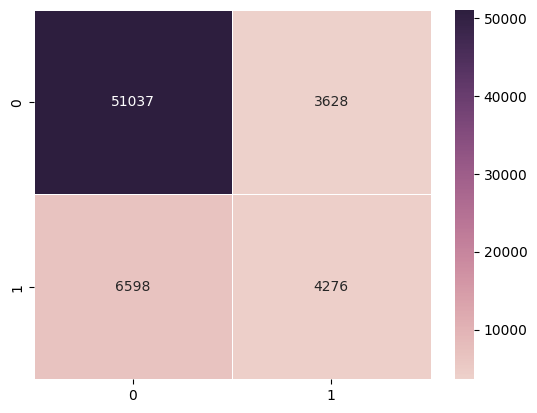

In [49]:
# Display confusion matrix
print("\nConfusion Matrix:")

cf_matrix=confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sn.cubehelix_palette(as_cmap=True),linewidth=.5)

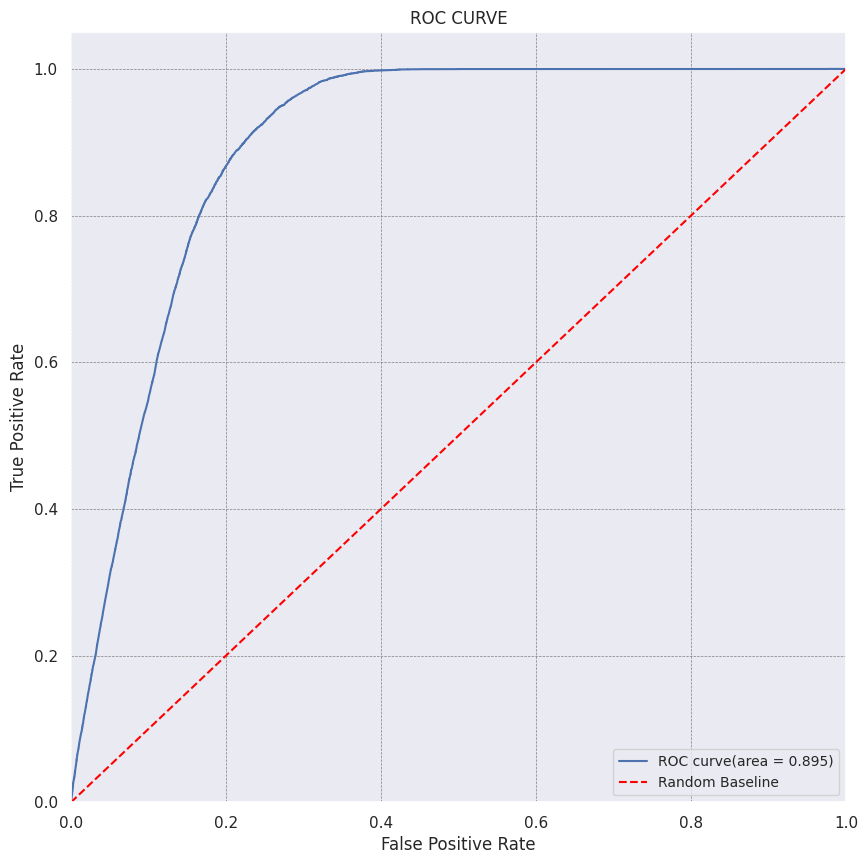

In [50]:
# Plot Roc Curve
fig = plt.figure(figsize=(10, 10))
# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(y_test,best_parm_model.predict_proba(X_test)[:,1].ravel())
roc_auc = auc(fpr, tpr)
sn.set()
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')

In [51]:
# training the model on whole dataset and saving
best_parm_model.fit(data,target)
# Save the best model using pickle
with open('XGBoost.pkl', 'wb') as file:
    pickle.dump(best_parm_model, file)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


RandomForestClassifier

In [52]:
rf = RandomForestClassifier(random_state=0)
K_selector =  SelectKBest()

# Create the pipeline
pipeline_rf = create_pipeline(rf,feature_selection=K_selector)

pipeline_rf

Pipeline(steps=[('feature_select', SelectKBest()),
                ('classifier', RandomForestClassifier(random_state=0))])

In [53]:
param_grid_rf = {
    'feature_select__k': [7, 10,12,14,17],
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, None],
    "classifier__min_samples_split": [2, 5, 10],
}

# Cross-validation method
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Search for best hyperparameters
search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=cv_strategy,
    scoring='f1_macro',
    random_state=42,
    n_iter=5  
).fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/

In [54]:
print('BEST PARAMS:', search_rf.best_params_)
best_parm_model_rf = search_rf.best_estimator_.fit(X_train,y_train)

BEST PARAMS: {'feature_select__k': 7, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': None}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [55]:
y_pred = best_parm_model_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

report = classification_report(y_test, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
print(results)

Accuracy: 0.8386304337875158
              precision    recall  f1-score      support
0              0.863585  0.957834  0.908271  54665.00000
1              0.530359  0.239378  0.329869  10874.00000
accuracy       0.838630  0.838630  0.838630      0.83863
macro avg      0.696972  0.598606  0.619070  65539.00000
weighted avg   0.808297  0.838630  0.812305  65539.00000



Confusion Matrix:


<Axes: >

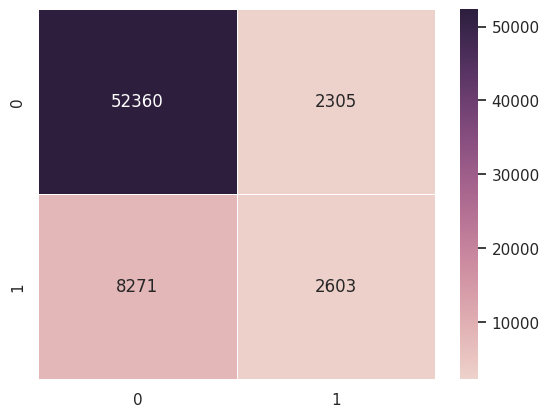

In [56]:
# Display confusion matrix
print("\nConfusion Matrix:")

cf_matrix=confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sn.cubehelix_palette(as_cmap=True),linewidth=.5)

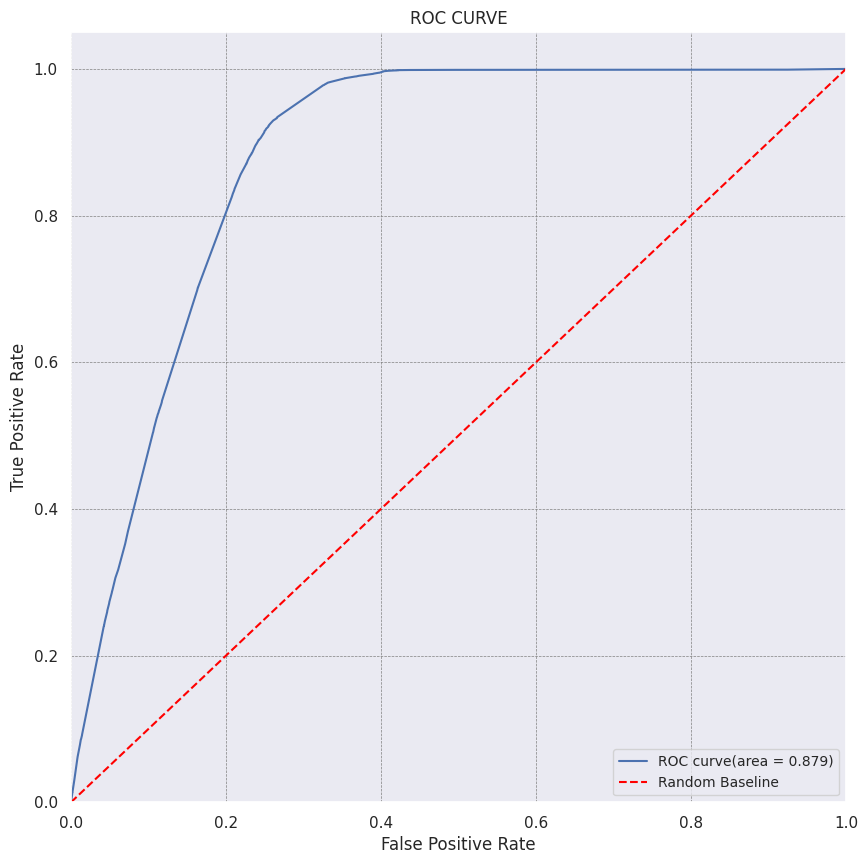

In [57]:
# Plot Roc Curve
fig = plt.figure(figsize=(10, 10))
# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(y_test,best_parm_model_rf.predict_proba(X_test)[:,1].ravel())
roc_auc = auc(fpr, tpr)
sn.set()
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')

In [58]:
# training the model on whole dataset and saving
best_parm_model_rf.fit(data,target)
# Save the best model using pickle
with open('RandomForestClassifier.pkl', 'wb') as file:
    pickle.dump(best_parm_model_rf, file)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Lgbm

In [59]:
lgbm_Classifier = lgb.LGBMClassifier()
Rfe = RFE(estimator=DecisionTreeClassifier())

# Create the pipeline
pipeline_lg = create_pipeline(lgbm_Classifier,feature_selection=Rfe)

pipeline_lg

Pipeline(steps=[('feature_select', RFE(estimator=DecisionTreeClassifier())),
                ('classifier', LGBMClassifier())])

In [60]:
# Cross-validation method
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid_lg = {'classifier__learning_rate': [0.01, 0.05, 0.1],
                 'classifier__n_estimators' : [200,500,1000],
               'feature_select__n_features_to_select': [1,3,5,7,None],

}
# Search for best hyperparameters
search_lg = RandomizedSearchCV(
    pipeline_lg,
    param_grid_lg,
    cv=cv_strategy,
    scoring='f1_macro',
    random_state=42,
    n_iter=5  
).fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 28997, number of negative: 145773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 174770, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165915 -> initscore=-1.614858
[LightGBM] [Info] Start training from score -1.614858
[LightGBM] [Info] Number of positive: 28998, number of negative: 145773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 174771, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165920 -> initscore=-1.614824
[LightGBM] [Info] Start training from score -1.614824
[LightGBM] [

In [61]:
print('BEST PARAMS:', search_lg.best_params_)
best_parm_model_lgbm = search_lg.best_estimator_.fit(X_train,y_train)

BEST PARAMS: {'feature_select__n_features_to_select': None, 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.1}
[LightGBM] [Info] Number of positive: 43496, number of negative: 218660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 262156, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165916 -> initscore=-1.614849
[LightGBM] [Info] Start training from score -1.614849


In [62]:
y_pred = best_parm_model_lgbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

report = classification_report(y_test, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
print(results)

Accuracy: 0.8370435923648515
              precision    recall  f1-score       support
0              0.871238  0.944169  0.906238  54665.000000
1              0.515402  0.298510  0.378057  10874.000000
accuracy       0.837044  0.837044  0.837044      0.837044
macro avg      0.693320  0.621340  0.642148  65539.000000
weighted avg   0.812199  0.837044  0.818605  65539.000000



Confusion Matrix:


<Axes: >

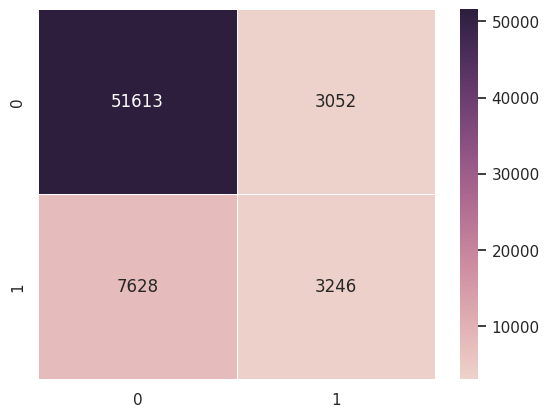

In [63]:

print("\nConfusion Matrix:")

cf_matrix=confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sn.cubehelix_palette(as_cmap=True),linewidth=.5)

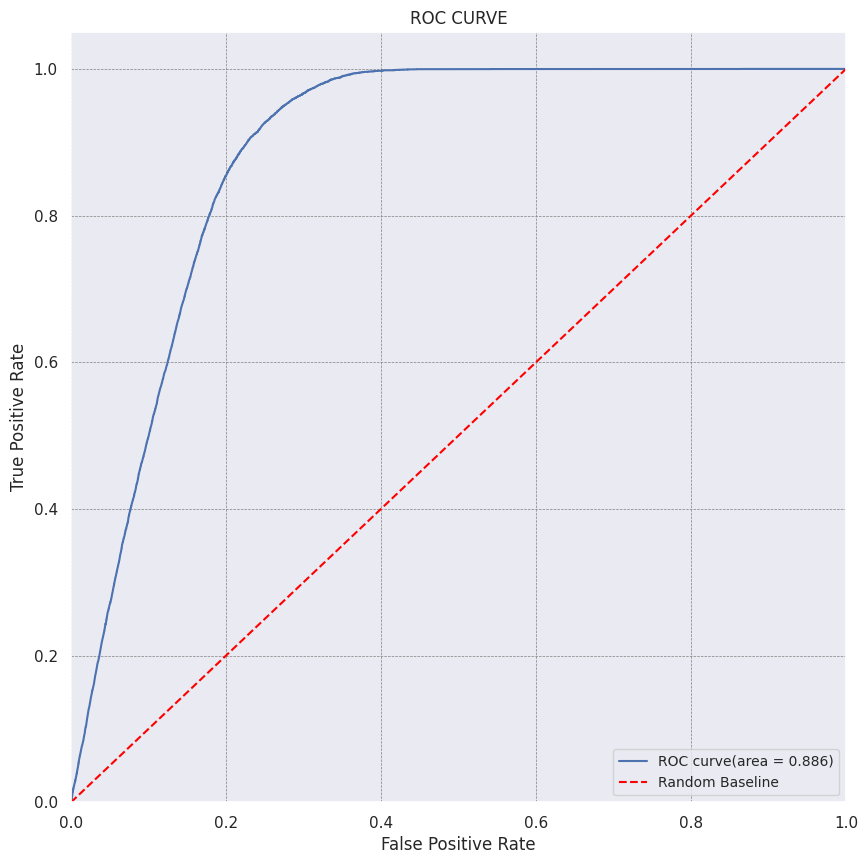

In [64]:
# Plot Roc Curve
fig = plt.figure(figsize=(10, 10))
# Get FPR, TPR and AUC
fpr, tpr, _ = roc_curve(y_test,best_parm_model_lgbm.predict_proba(X_test)[:,1].ravel())
roc_auc = auc(fpr, tpr)
sn.set()
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')

In [65]:
best_parm_model_lgbm.fit(data,target)

with open('LightGBM.pkl', 'wb') as file:
    pickle.dump(best_parm_model_lgbm, file)

[LightGBM] [Info] Number of positive: 54370, number of negative: 273325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 327695, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165916 -> initscore=-1.614849
[LightGBM] [Info] Start training from score -1.614849


In [68]:
XgBoost = pickle.load(open('/content/XGBoost.pkl','rb'))
Rf=pickle.load(open('/content/RandomForestClassifier.pkl','rb'))
LGbm=pickle.load(open('/content/LightGBM.pkl','rb'))

classifier_pipeline=[XgBoost,Rf,LGbm]

In [69]:
best_accuracy=[]
best_classifier=0
best_pipeline=""
pipe_dict={0:'XgBoost Classifier',1:'RandomForest Classifier',2:'LGbm Classifier'}

In [70]:
for i, model in enumerate(classifier_pipeline):

    y_pred = model.predict(X_test)
    print("{} Test Accuracy : {}".format(pipe_dict[i], model.score(X_test, y_test)))

    report = classification_report(y_test, y_pred, output_dict=True)
    results = pd.DataFrame(report).transpose()

    print(results)

XgBoost Classifier Test Accuracy : 0.8446573795755199
              precision    recall  f1-score       support
0              0.885450  0.934675  0.909397  54665.000000
1              0.544225  0.392128  0.455823  10874.000000
accuracy       0.844657  0.844657  0.844657      0.844657
macro avg      0.714837  0.663401  0.682610  65539.000000
weighted avg   0.828835  0.844657  0.834141  65539.000000
RandomForest Classifier Test Accuracy : 0.839790048673309
              precision    recall  f1-score      support
0              0.864404  0.958237  0.908905  54665.00000
1              0.537854  0.244344  0.336031  10874.00000
accuracy       0.839790  0.839790  0.839790      0.83979
macro avg      0.701129  0.601290  0.622468  65539.00000
weighted avg   0.810224  0.839790  0.813856  65539.00000
LGbm Classifier Test Accuracy : 0.8467477379880681
              precision    recall  f1-score       support
0              0.876504  0.950133  0.911834  54665.000000
1              0.566062  0.3270

In [71]:
best_model=[]
for i,model in enumerate(classifier_pipeline):
    best_model.append(model.score(X_test,y_test))
best_classifier=best_model.index(max(best_model))
print('Classifier with best Accuracy : {}.'.format(pipe_dict[best_classifier]))

Classifier with best Accuracy : LGbm Classifier.


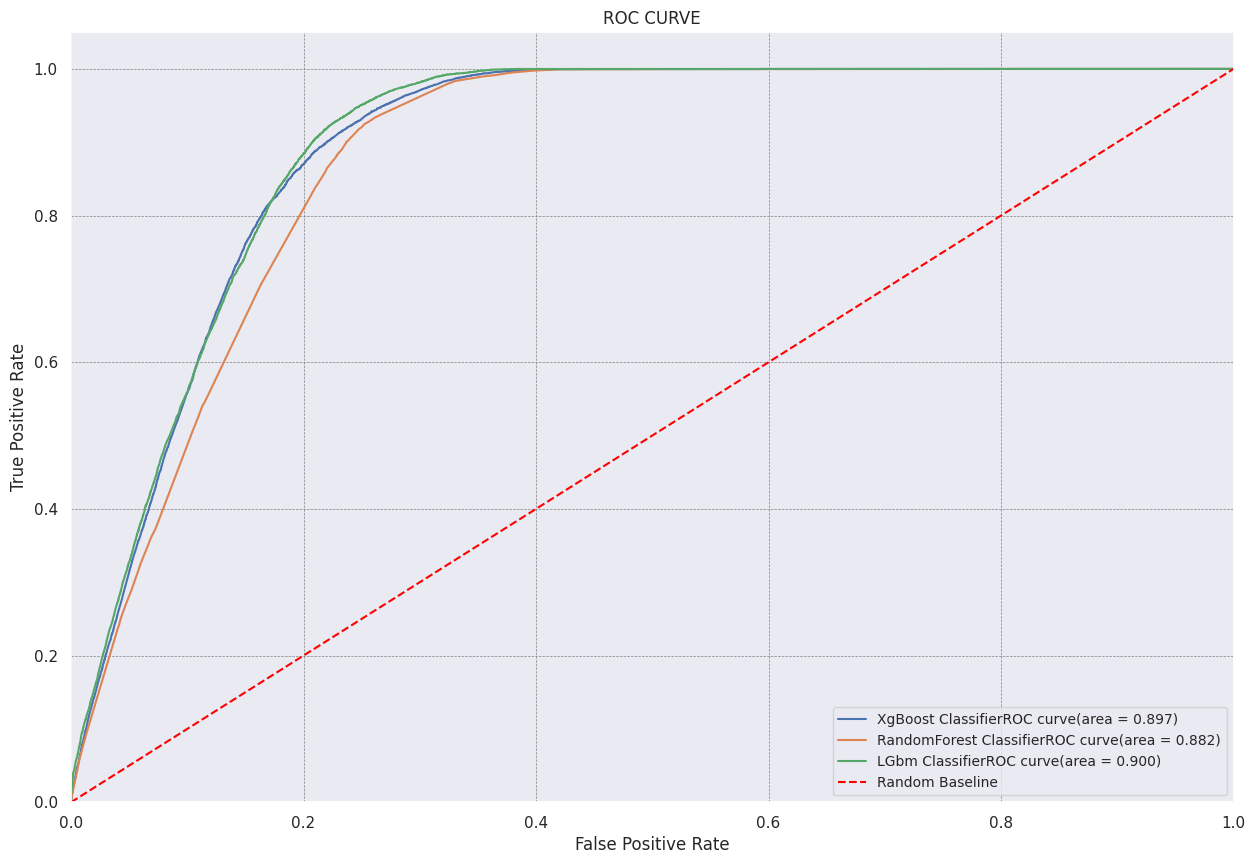

In [72]:
fig = plt.figure(figsize=(15, 10))
for i,model in enumerate(classifier_pipeline):

# Get FPR, TPR and AUC
    predictions=model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test,predictions[:,1].ravel())
    roc_auc = auc(fpr, tpr)
    sn.set()
    plt.plot(fpr, tpr, label=str(pipe_dict[i])+"ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right", fontsize='small')

Text(0.5, 1.0, '2-class Precision-Recall curve')

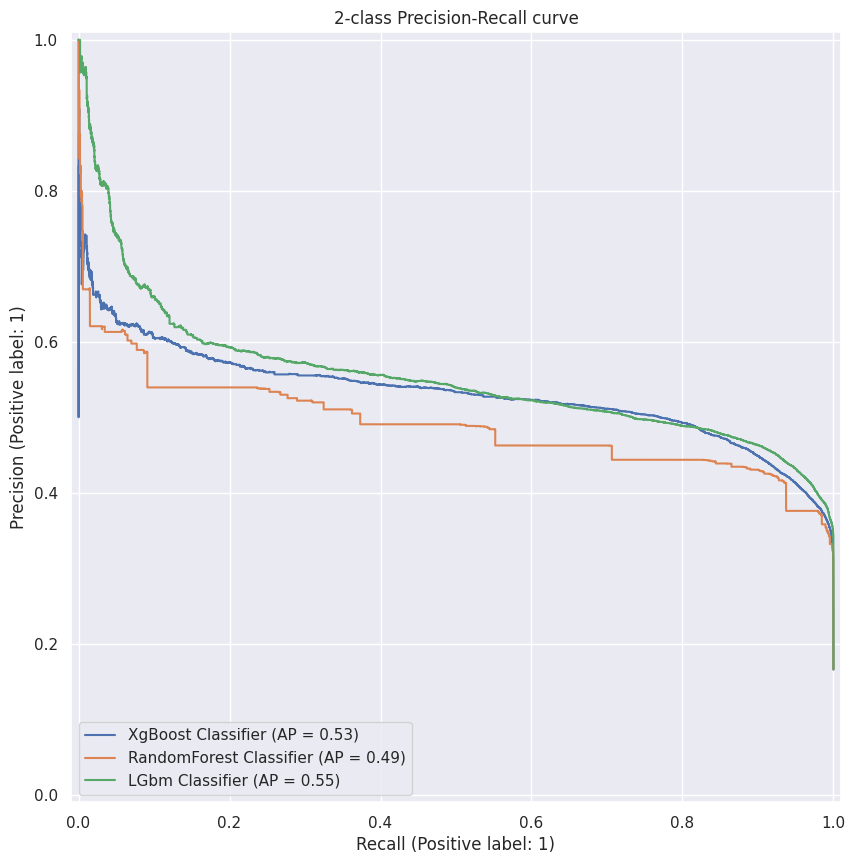

In [73]:
fig = plt.figure(figsize=(15, 10))
sn.set()
for i,model in enumerate(classifier_pipeline):
    display= PrecisionRecallDisplay.from_estimator(model,X_test, y_test, ax = plt.gca(),name = pipe_dict[i])
display.ax_.set_title("2-class Precision-Recall curve")

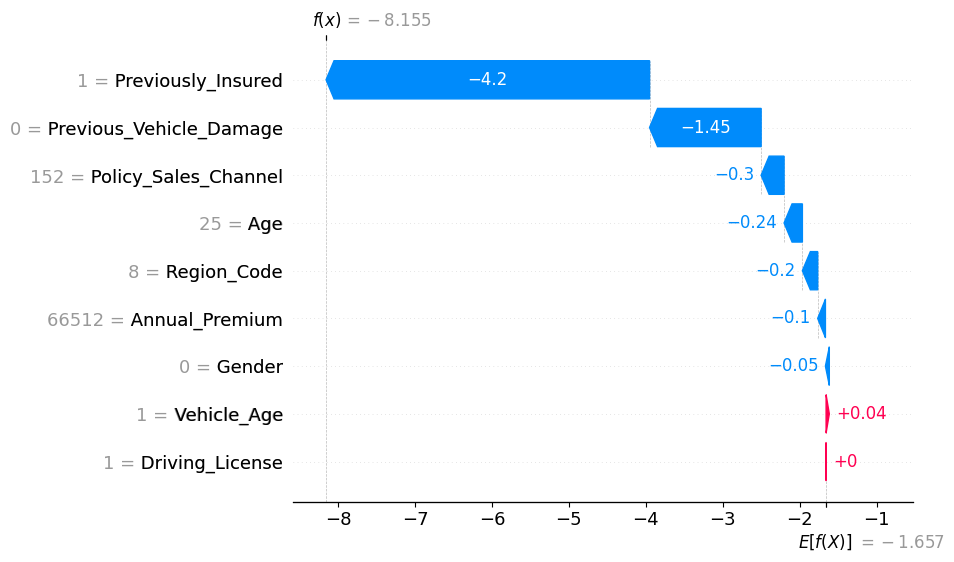

In [29]:
import shap

model = XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


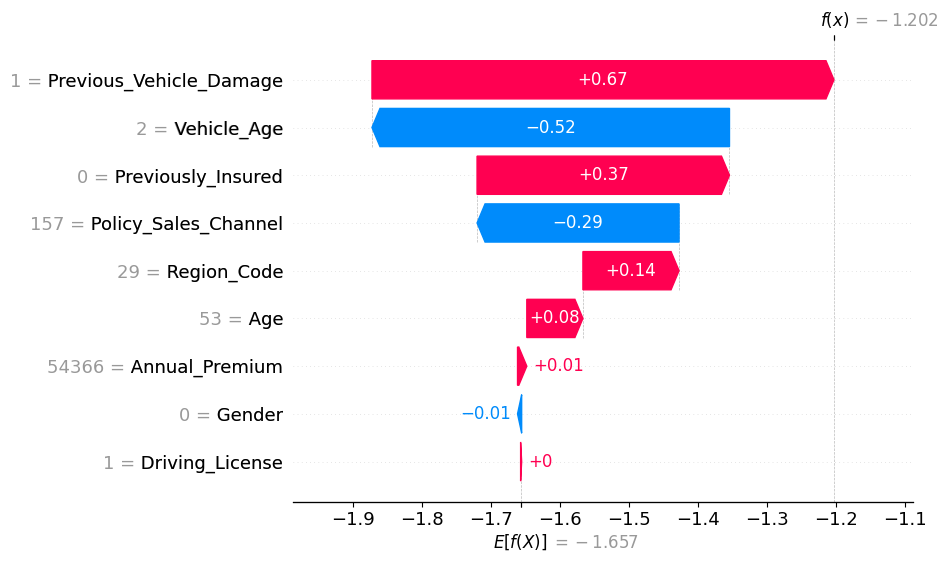

In [30]:
shap.plots.waterfall(shap_values[1])

In [31]:
X_train.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Previous_Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel'],
      dtype='object')